##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# Basic text classification

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs/blob/master/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs/site/en/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This tutorial demonstrates text classification starting from plain text files stored on disk. ~~You'll train a binary classifier to perform sentiment analysis on an IMDB dataset~~. At the end of the notebook, **there is an exercise for you to try, in which you'll train a multi-class classifier to predict the tag for a programming question on Stack Overflow.** <-this is it :)


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


In [48]:
print(tf.__version__)

2.18.0


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review. This is an example of *binary*—or two-class—classification, an important and widely applicable kind of machine learning problem.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/). These are split into 25,000 reviews for training and 25,000 reviews for testing. The training and testing sets are *balanced*, meaning they contain an equal number of positive and negative reviews.


### Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [4]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"

dataset = tf.keras.utils.get_file("stack_overflow_16k", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'stack_overflow_16k')

6053168/6053168 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [5]:
os.listdir(dataset_dir)

['test', '.gitignore', 'README.md', 'train']

In [18]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')
os.listdir(train_dir)

['javascript', 'python', 'csharp', 'java']

The `aclImdb/train/pos` and `aclImdb/train/neg` directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [8]:
sample_file = os.path.join(train_dir, 'python/118.txt')
with open(sample_file) as f:
  print(f.read())

"what's the correct way to change a value that is imported by other modules? i have my entry point script take a cli option argument using argsparser and that looks something like this:..    import some_module..    if __name__== ""__main__"":.        parser = argparse.argumentparser(description='nemo node.').        parser.add_argument('-t', '--test', dest='testing', action=""store_true"")..        # handle cli params and options.        # .......        some_module.run()...i want the -t option to change a parameter testing in a config script settings.py, since my some_module uses things like :..from settings import testing.if testing:.   # do some testing stuff...because of this testing is already imported into some_module by the time i handle the args, changes to settings.py can no longer have any effect on some_module..my answer is what's the correct practice in dealing with this:...import some_module inside the __main__ after the args have been parsed?.replace testing by settings.t

### Load the dataset

Next, you will load the data off disk and prepare it into a format suitable for training. To do so, you will use the helpful [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) utility, which expects a directory structure as follows.

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to `class_a` and `class_b`. These will be the positive and negative movie reviews, which can be found in  `aclImdb/train/pos` and `aclImdb/train/neg`. As the IMDB dataset contains additional folders, you will remove them before using this utility.

Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`. [tf.data](https://www.tensorflow.org/guide/data) is a powerful collection of tools for working with data.

When running a machine learning experiment, it is a best practice to divide your dataset into three splits: [train](https://developers.google.com/machine-learning/glossary#training_set), [validation](https://developers.google.com/machine-learning/glossary#validation_set), and [test](https://developers.google.com/machine-learning/glossary#test-set).

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

In [11]:
#changes: instead of splitting the validation from the train, let's split it from the test and keep train complete.
#in the end, it increased accuracy from ~86% to ~87%

batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    )

'''raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)'''

Found 8000 files belonging to 4 classes.


"raw_train_ds = tf.keras.utils.text_dataset_from_directory(\n    'aclImdb/train',\n    batch_size=batch_size,\n    validation_split=0.2,\n    subset='training',\n    seed=seed)"

As you can see above, there are 25,000 examples in the training folder, of which you will use 80% (or 20,000) for training. As you will see in a moment, you can train a model by passing a dataset directly to `model.fit`. If you're new to `tf.data`, you can also iterate over the dataset and print out a few examples as follows.

In [13]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Question: ", text_batch.numpy()[i])
    print("Label: ", label_batch.numpy()[i])

Question:  b'"one of the examples in the book ""blank - the definitive guide"" not working i\'m reading blank - the definitive guide. i usually try to imitate the examples they give so i can learn it more quickly, that\'s just how i learn. but i rewrote this blank and it doesn\'t seem to be working. whenever i input the numbers and hit calculate it doesn\'t calculate...i\'ve already tried looking for an answer elsewhere, but found nothing...&lt;html&gt;.&lt;body&gt;.&lt;head&gt;&lt;title&gt;factorials&lt;/title&gt;&lt;/head&gt;....&lt;form name=""loandata""&gt;.    &lt;table&gt;.        &lt;tr&gt;.            &lt;td colspan=""3""&gt;&lt;b&gt;enter loan information:&lt;/b&gt;&lt;/td&gt;.        &lt;/tr&gt;.        &lt;tr&gt;.            &lt;td&gt;1)&lt;/td&gt;.            &lt;td&gt;amount of the loan (any currency):&lt;/td&gt;.            &lt;td&gt;&lt;input type=""text"" name=""principal"" size=""12"".                        onchange=""calculate();"" /&gt;&lt;/td&gt;.        &lt;/tr&gt

2025-02-17 20:25:18.538155: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Notice the reviews contain raw text (with punctuation and occasional HTML tags like `<br/>`). You will show how to handle these in the following section.

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, you can check the `class_names` property on the dataset.


In [17]:
for i, label in enumerate(raw_train_ds.class_names):
    print(f"Label {i} corresponds to {label}")

Label 0 corresponds to csharp
Label 1 corresponds to java
Label 2 corresponds to javascript
Label 3 corresponds to python


Next, you will create a validation and test dataset. You will use the remaining 5,000 reviews from the training set for validation.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [19]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

'''raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)'''

Found 8000 files belonging to 4 classes.
Using 1600 files for validation.


"raw_val_ds = tf.keras.utils.text_dataset_from_directory(\n    'aclImdb/train',\n    batch_size=batch_size,\n    validation_split=0.2,\n    subset='validation',\n    seed=seed)"

In [20]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size,
    )

'''raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)'''

Found 8000 files belonging to 4 classes.


"raw_test_ds = tf.keras.utils.text_dataset_from_directory(\n    'aclImdb/test',\n    batch_size=batch_size)"

### Prepare the dataset for training

Next, you will standardize, tokenize, and vectorize the data using the helpful `tf.keras.layers.TextVectorization` layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network. All of these tasks can be accomplished with this layer.

As you saw above, the reviews contain various HTML tags like `<br />`. These tags will not be removed by the default standardizer in the `TextVectorization` layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). You will write a custom standardization function to remove the HTML.

Note: To prevent [training-testing skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew) (also known as training-serving skew), it is important to preprocess the data identically at train and test time. To facilitate this, the `TextVectorization` layer can be included directly inside your model, as shown later in this tutorial.

In [21]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

Next, you will create a `TextVectorization` layer. You will use this layer to standardize, tokenize, and vectorize our data. You set the `output_mode` to `int` to create unique integer indices for each token.

Note that you're using the default split function, and the custom standardization function you defined above. You'll also define some constants for the model, like an explicit maximum `sequence_length`, which will cause the layer to pad or truncate sequences to exactly `sequence_length` values.

In [22]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

Next, you will call `adapt` to fit the state of the preprocessing layer to the dataset. This will cause the model to build an index of strings to integers.

Note: It's important to only use your training data when calling adapt (using the test set would leak information).

In [23]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [24]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [25]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'"is this the same code for blank dictionary? if d is a blank dictionary, are these two lines the same thing?..if d in d:...vs:..if d in d.keys():...i am reading other people\' code and found these two lines in very close locations. i think they should be the the same and should be changed to the first version. right?"\n', shape=(), dtype=string)
Label python
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[   6,   13,    2,  119,   30,   12,   16,  391,   10,  240,    6,
           5,   16,  391,   62,  228,  120,  286,    2,  119,    1,  240,
           7,    1,  240,    7,    1,   35,  447,  140,  889,   30,    8,
         227,  228,  120,  286,    7,  284,  614, 4022,    3,  296,  199,
          92,   33,    2,    2,  119,    8,   92,   33,  760,    4,    2,
         100,  470,  217,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    

As you can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling `.get_vocabulary()` on the layer.

In [26]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  equivalent
 313 --->  must
Vocabulary size: 10000


You are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset.

In [27]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### Configure the dataset for performance

These are two important methods you should use when loading data to make sure that I/O does not become blocking.

`.cache()` keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

`.prefetch()` overlaps data preprocessing and model execution while training.

You can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance).

In [28]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model

It's time to create your neural network:

In [34]:
embedding_dim = 16

In [35]:
model = tf.keras.Sequential([
  layers.Embedding(max_features, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(4, activation='sigmoid')])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_2      │ ?                      │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

The layers are stacked sequentially to build the classifier:

1. The first layer is an `Embedding` layer. This layer takes the integer-encoded reviews and looks up an embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: `(batch, sequence, embedding)`.  To learn more about embeddings, check out the [Word embeddings](https://www.tensorflow.org/text/guide/word_embeddings) tutorial.
2. Next, a `GlobalAveragePooling1D` layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. The last layer is densely connected with a single output node.

### Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use `losses.BinaryCrossentropy` loss function.

Now, configure the model to use an optimizer and a loss function:

In [36]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=['accuracy'])

### Train the model

You will train the model by passing the `dataset` object to the fit method.

In [38]:
epochs = 20
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7921 - loss: 0.6568 - val_accuracy: 0.7713 - val_loss: 0.6850
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7995 - loss: 0.6249 - val_accuracy: 0.7800 - val_loss: 0.6616
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8132 - loss: 0.5926 - val_accuracy: 0.7831 - val_loss: 0.6407
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8184 - loss: 0.5659 - val_accuracy: 0.7944 - val_loss: 0.6217
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8270 - loss: 0.5443 - val_accuracy: 0.7906 - val_loss: 0.6088
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8327 - loss: 0.5232 - val_accuracy: 0.7950 - val_loss: 0.5962
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8343 - loss: 0.5060 - val_accuracy: 0.7944 - val_loss: 0.5839
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8474 - loss: 0.4850 - val_accuracy: 0.

### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [39]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

250/250 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7970 - loss: 0.5362
Loss:  0.5350964069366455
Accuracy:  0.797249972820282


This fairly naive approach achieves an accuracy of about 86%.

### Create a plot of accuracy and loss over time

`model.fit()` returns a `History` object that contains a dictionary with everything that happened during training:

In [40]:
history_dict = history.history
history_dict.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

There are four entries: one for each monitored metric during training and validation. You can use these to plot the training and validation loss for comparison, as well as the training and validation accuracy:

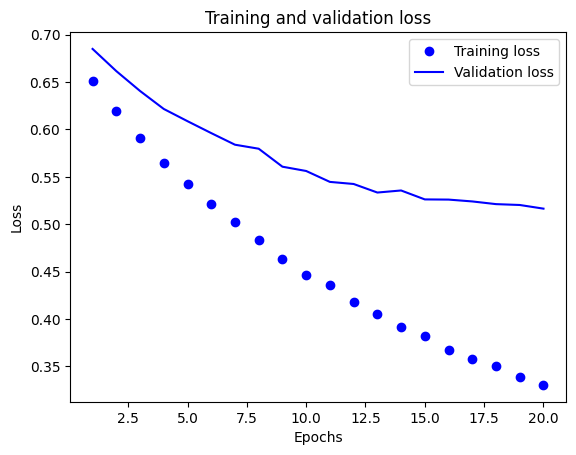

In [41]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

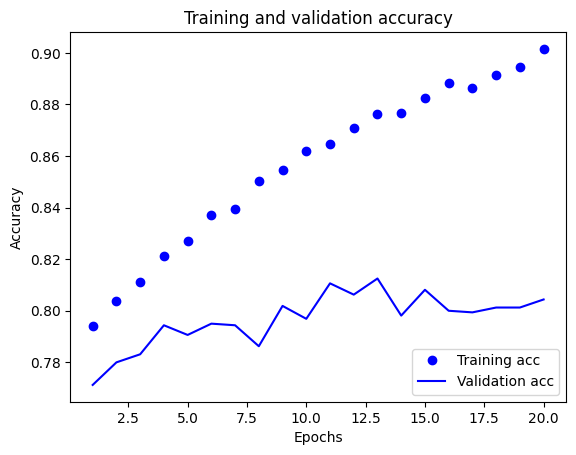

In [42]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

In this plot, the dots represent the training loss and accuracy, and the solid lines are the validation loss and accuracy.

Notice the training loss *decreases* with each epoch and the training accuracy *increases* with each epoch. This is expected when using a gradient descent optimization—it should minimize the desired quantity on every iteration.

This isn't the case for the validation loss and accuracy—they seem to peak before the training accuracy. This is an example of overfitting: the model performs better on the training data than it does on data it has never seen before. After this point, the model over-optimizes and learns representations *specific* to the training data that do not *generalize* to test data.

For this particular case, you could prevent overfitting by simply stopping the training when the validation accuracy is no longer increasing. One way to do so is to use the `tf.keras.callbacks.EarlyStopping` callback.

## Export the model

In the code above, you applied the `TextVectorization` layer to the dataset before feeding text to the model. If you want to make your model capable of processing raw strings (for example, to simplify deploying it), you can include the `TextVectorization` layer inside your model. To do so, you can create a new model using the weights you just trained.

In [44]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model
  #layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.SparseCategoricalCrossentropy(from_logits=True), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
metrics = export_model.evaluate(raw_val_ds, return_dict=True)
print(metrics)

/home/andreati/Coding/Learning/TensorFlow/.venvTF/lib/python3.12/site-packages/keras/src/backend/tensorflow/nn.py:708: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8139 - loss: 0.4897
{'accuracy': 0.8043749928474426, 'loss': 0.5164363384246826}


### Inference on new data

To get predictions for new examples, you can simply call `model.predict()`.

In [63]:
class_names = raw_train_ds.class_names

examples = tf.constant([
  "overloaded versions of writeline; why not use generics/template? .  the system.console type offers several overloaded versions of the writeline method (boolean, char, int32)...so basically the sentence is saying when implementing writeline for different primitive types, they overloaded the function a couple of times..instead of writing so many functions for different types, why don't they use generics / templating ?..if it is in c++, i would assume templating in such scenarios are better solutions compared with overloaded versions of similar functions. don't know the incentive here...next line:.for the sole purpose of reducing number of boxing operations for the common value types .....how does these reduce boxing count then? constructing the string directly instead of calling tostring ?",
  '"jasperreport : net.sf.jasperreports.engine.jrexception out line:..net.sf.jasperreports.engine.jrexception: com.sun.org.apache.xerces.internal.impl.io.malformedbytesequenceexception...i using..netbeans 7.2 + ireport plugin for netbeans 7.2(ireport4.7.1).working with the plugin works in netbeans but when running the problem.libraries:...jasperreports-4.7.1.jar.commons-beanutils-1.8.2.jar.commons-codec-1.6.jar.commons-collections-3.2.1.jar.commons-digester-1.7.jar.commons-logging 1.1.jar.jasperreports-4.7.1.jar...code:..try{.                string rutareport = ""src\pckreports\rboleta.jasper"";.                map param = new hashmap();.                param.put(""numcomprobante"",txtcorrelativo.gettext());.                param.put(""numserie"",txtserie.gettext());.                param.put(""tipocomprobante"", bol);.                param.put(""numletra"",letra);.                jasperreport lreporte = jaspercompilemanager.compilereport(rutareport);.                //jasperreport lreporte = jaspercompilemanager.compilereport(""pckreports\rboleta.jrxml"");.                jasperprint jasp = jasperfillmanager.fillreport(lreporte, param, this.jcn.con());.                //jasperexportmanager.exportreporttopdffile(jasp, ""d:\informepaisesmysql.pdf"");.                jasperviewer ventana = new jasperviewer(jasp,false); .                ventana.settitle(""boleta de venta -""+fechaemisionbol());.                ventana.setvisible(true);.            }catch(headlessexception | jrexception ex){.                joptionpane.showmessagedialog(null, ex);.                system.out.println(""""+ex);.            }"',
  "blank pass get params i get exists get params on request:..?filterby=1,2,3...how i can pass params after filterby with js?..my solution:..switch(type) {.        case 'status':.            window.location.href = '?filter-status=i=' + filters;.        break;.        case 'oldfrom':.            window.location.href = '?oldfrom';.        break;.        case 'oldto':.            window.location.href = '?oldto';.        break;.        case 'newfrom':.            window.location.href = '?newfrom';.        break;.        case 'newto':.            window.location.href = '?newto';.        break;.        case 'catesel':.            window.location.href = '?bycategory=' + filters;.        break;.    }...in my case i rewrite get params. .example: if i have exists param on request: bycategory=1,2,3 and when i click button to add new filter by request is remove and write new. how i can do this:..?bycategory=1,2,3&amp;newfrom .....i need remove window.location.href or how pass exists get params?",
  "prime factorization algorithm i'm trying to write function to find the prime factorization of a given number.  it need not be fast, or efficient, it just needs to work...here is my idea:...pick a number and a starting point (which will be 2)..if the number is divisible by 2, add one to a counter and divide the number by 2.  .when the number is not divisible by 2, change your starting point to 3..repeat....here is my code:..def ffs(num):..factors={}..n=2..while n&lt;num:..    while num%n==0:..        num=num/n..        if n in factors:.            factors[n]+=1.        else:.            factors[n]=1...    n+=1..return factors...i run into some problems early on.  when i try to evaluate ffs(6) i should get {2: 1, 3:1}, but instead i get {2: 1}.  can someone try to spot my error?"
])

for predict in export_model.predict(examples):
    print(class_names[np.argmax(predict)])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
csharp
java
javascript
python


<>:5: SyntaxWarning: invalid escape sequence '\p'
<>:5: SyntaxWarning: invalid escape sequence '\p'
/tmp/ipykernel_24113/3652128930.py:5: SyntaxWarning: invalid escape sequence '\p'
  '"jasperreport : net.sf.jasperreports.engine.jrexception out line:..net.sf.jasperreports.engine.jrexception: com.sun.org.apache.xerces.internal.impl.io.malformedbytesequenceexception...i using..netbeans 7.2 + ireport plugin for netbeans 7.2(ireport4.7.1).working with the plugin works in netbeans but when running the problem.libraries:...jasperreports-4.7.1.jar.commons-beanutils-1.8.2.jar.commons-codec-1.6.jar.commons-collections-3.2.1.jar.commons-digester-1.7.jar.commons-logging 1.1.jar.jasperreports-4.7.1.jar...code:..try{.                string rutareport = ""src\pckreports\rboleta.jasper"";.                map param = new hashmap();.                param.put(""numcomprobante"",txtcorrelativo.gettext());.                param.put(""numserie"",txtserie.gettext());.                param.put(""tipocomproba

Including the text preprocessing logic inside your model enables you to export a model for production that simplifies deployment, and reduces the potential for [train/test skew](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew).

There is a performance difference to keep in mind when choosing where to apply your TextVectorization layer. Using it outside of your model enables you to do asynchronous CPU processing and buffering of your data when training on GPU. So, if you're training your model on the GPU, you probably want to go with this option to get the best performance while developing your model, then switch to including the TextVectorization layer inside your model when you're ready to prepare for deployment.

Visit this [tutorial](https://www.tensorflow.org/tutorials/keras/save_and_load) to learn more about saving models.

## Exercise: multi-class classification on Stack Overflow questions

This tutorial showed how to train a binary classifier from scratch on the IMDB dataset. As an exercise, you can modify this notebook to train a multi-class classifier to predict the tag of a programming question on [Stack Overflow](http://stackoverflow.com/).

A [dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) has been prepared for you to use containing the body of several thousand programming questions (for example, "How can I sort a dictionary by value in Python?") posted to Stack Overflow. Each of these is labeled with exactly one tag (either Python, CSharp, JavaScript, or Java). Your task is to take a question as input, and predict the appropriate tag, in this case, Python.

The dataset you will work with contains several thousand questions extracted from the much larger public Stack Overflow dataset on [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow), which contains more than 17 million posts.

After downloading the dataset, you will find it has a similar directory structure to the IMDB dataset you worked with previously:

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

Note: To increase the difficulty of the classification problem, occurrences of the words Python, CSharp, JavaScript, or Java in the programming questions have been replaced with the word *blank* (as many questions contain the language they're about).

To complete this exercise, you should modify this notebook to work with the Stack Overflow dataset by making the following modifications:

1. At the top of your notebook, update the code that downloads the IMDB dataset with code to download the [Stack Overflow dataset](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz) that has already been prepared. As the Stack Overflow dataset has a similar directory structure, you will not need to make many modifications.

1. Modify the last layer of your model to `Dense(4)`, as there are now four output classes.

1. When compiling the model, change the loss to `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)`. This is the correct loss function to use for a multi-class classification problem, when the labels for each class are integers (in this case, they can be 0, *1*, *2*, or *3*). In addition, change the metrics to `metrics=['accuracy']`, since this is a multi-class classification problem (`tf.metrics.BinaryAccuracy` is only used for binary classifiers).

1. When plotting accuracy over time, change `binary_accuracy` and `val_binary_accuracy` to `accuracy` and `val_accuracy`, respectively.

1. Once these changes are complete, you will be able to train a multi-class classifier.

## Learning more

This tutorial introduced text classification from scratch. To learn more about the text classification workflow in general, check out the [Text classification guide](https://developers.google.com/machine-learning/guides/text-classification/) from Google Developers.
